# PXD018886 Gygi lab mouse liver re-analysis

## CC Strains

## Quality control and sanity check notebook

### performed by Phil Wilmarth, PSR Core OHSU

#### November 9, 2025

---

- [Overview](#overview) 
- [Data loading](#load_data)
- [Removing plex effects with IRS](#IRS)
- [TMM normalization and final clustering](#TMM)
- [CV distributions](#CVs)
- [Sample-to-sample scatter plots](#scatter_plots)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

This is a 12-plex experiment using 11-plex TMT with one reference channel per plex. Each plex is a set of biological replicates of mouse livers from the larger CC experiment. There are 58 diverse mice populations and one male and one female of each genotype had their liver tissues profiled uinsg SPS-MS3 TMT labeling. Data were downloaded from PRIDE (PXD018886) and processed with the [PAW Pipeline](https://github.com/pwilmart/PAW_pipeline) (*Wilmarth 2009*) and IRS normalized using the bridge channel in each plex. This is the publication:

> Keele, G.R., Zhang, T., Pham, D.T., Vincent, M., Bell, T.A., Hock, P., Shaw, G.D., Paulo, J.A., Munger, S.C., de Villena, F.P.M. and Ferris, M.T., 2021. Regulation of protein abundance in genetically diverse mouse populations. Cell Genomics, 1(1).

This QC notebook will address these questions:

- Do the samples cluster by biological group or by TMT plex?
- Are normalization factors small and consistent?
- Are samples within groups similar to each other?

### References

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

---

## This notebook examines quality control metrics

---

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# =========== Boxplot with median label ========================================
labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

## <a name="load_data"></a>Load the IRS-normalized TMT intensity data

The IRS-adjusted quantitative data was prepped in Excel. The IRS script excludes any flagged proteins (decoys, contaminants, blood proteins, etc.) and restricts the IRS adjustment to proteins seen in all three plexes. The IRS adjusted data was saved to a tab-delimited text file for input into this script.  

In [3]:
# load the IRS-normalized data and check the table
data_irs <- read_tsv("quant_table.txt") 

# save gene names for edgeR so we can double check that results line up
accessions <- data_irs$Accession

# see how many rows of data we have
length(accessions)

Rows: 5223 Columns: 133
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): Accession
dbl (132): CC04_M_1, CC57_F_1, CC42_M_1, CC13_M_1, CC02_M_1, CC43_M_1, CC41_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 5223

### Collect channels by biological conditions 

In [4]:
# define the groups (after IRS)
F_ <- select(data_irs, contains("_F_"))
M_ <- select(data_irs, contains("_M_"))

### Make the organized data frames

We will put the organized data into a new data frame, define some column indexes for each biological group, and set colors for plotting.

In [5]:
# put groups together into a single data frame
tmt_irs <- bind_cols(F_, M_)

# define which columns go with each group
F <- 1:60
M <- 61:120

# set some colors by group
colors_group = c(rep('red', 60), rep('blue', 60)) 

## <a name="IRS"></a>Clustering before and after IRS

We expect to see each of the plexes cluster together before IRS adjustment. The plex batch-like effect should be removed by the IRS method and the clustering after IRS should be by biological groups.

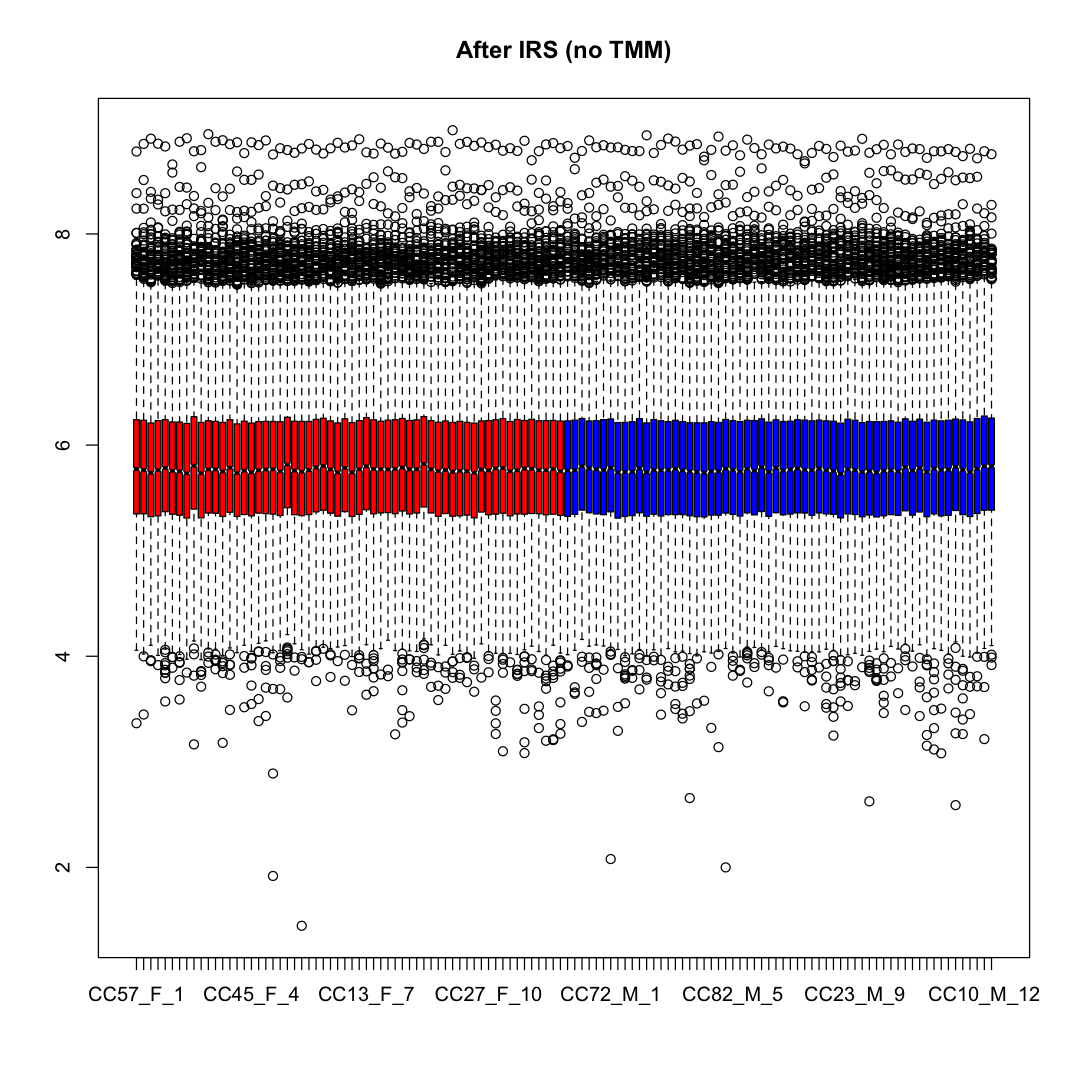

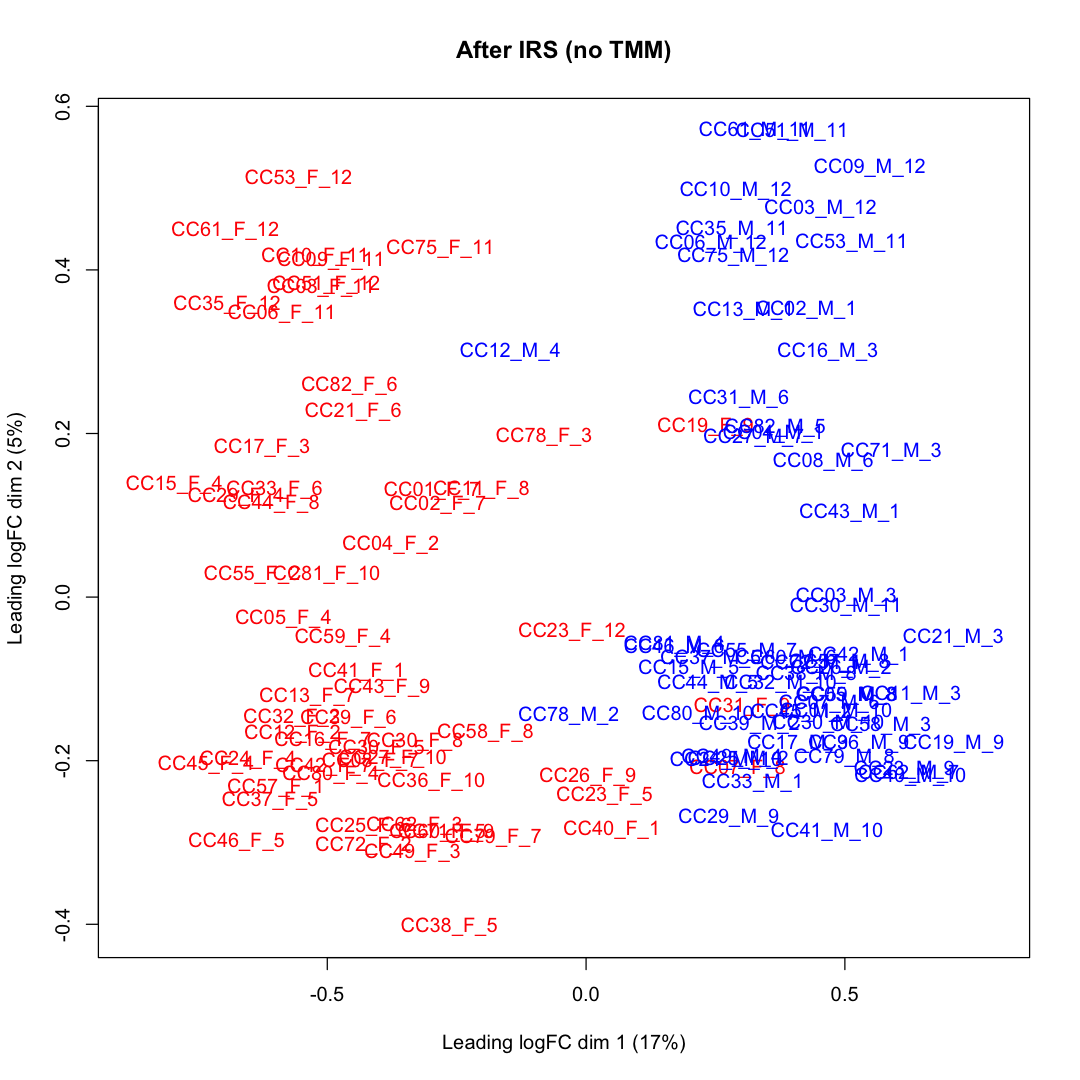

In [6]:
# make default plot sizes a little bigger
set_plot_dimensions(9, 9)

# boxplots after IRS and before TMM
boxplot(log10(tmt_irs), col = colors_group, notch = TRUE, main = "After IRS (no TMM)")

# check clustering before IRS
plotMDS(log2(tmt_irs), main = "After IRS (no TMM)", col = colors_group)

### Clustering is by sex, not by plex

The last character in the sample names are the plex numbers. The female mice are in red and on the left. The male micer are in blue and on the right.

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will load the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization to correct for any sample composition differences. We will double check if the TMM normalization changed the clustering that we had above. 

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 CC57_F_1 -> 1.007007
 CC41_F_1 -> 1.004325
 CC40_F_1 -> 1.003370
 CC04_F_2 -> 1.003263
 CC55_F_2 -> 1.006462
 CC32_F_2 -> 0.999437
 CC12_F_2 -> 1.000505
 CC72_F_2 -> 1.000847
 CC17_F_3 -> 1.004182
 CC49_F_3 -> 0.999488
 CC78_F_3 -> 1.000067
 CC62_F_3 -> 1.002296
 CC29_F_4 -> 0.999485
 CC24_F_4 -> 1.001080
 CC80_F_4 -> 0.999598
 CC59_F_4 -> 1.006084
 CC45_F_4 -> 0.994179
 CC05_F_4 -> 1.001600
 CC15_F_4 -> 0.993268
 CC46_F_5 -> 1.004911
 CC23_F_5 -> 0.996870
 CC30_F_5 -> 1.003010
 CC38_F_5 -> 1.002623
 CC37_F_5 -> 0.996284
 CC60_F_5 -> 1.001421
 CC39_F_6 -> 1.003664
 CC82_F_6 -> 1.007574
 CC21_F_6 -> 1.008816
 CC25_F_6 -> 0.999113
 CC33_F_6 -> 1.000187
 CC16_F_7 -> 1.001338
 CC02_F_7 -> 1.004085
 CC13_F_7 -> 1.001466
 CC79_F_7 -> 1.001803
 CC01_F_7 -> 1.000937
 CC08_F_7 -> 1.000388
 CC42_F_7 -> 1.001693
 CC44_F_8 -> 0.997941
 CC11_F_8 -> 1.002161
 CC58_F_8 -> 1.000193
 CC30_F_8 -> 1.000108
 CC07_F_8 -> 1.001228
 CC19_F_9 -> 0.999520
 CC31_F_9 -> 0.998379
 CC71_F_9

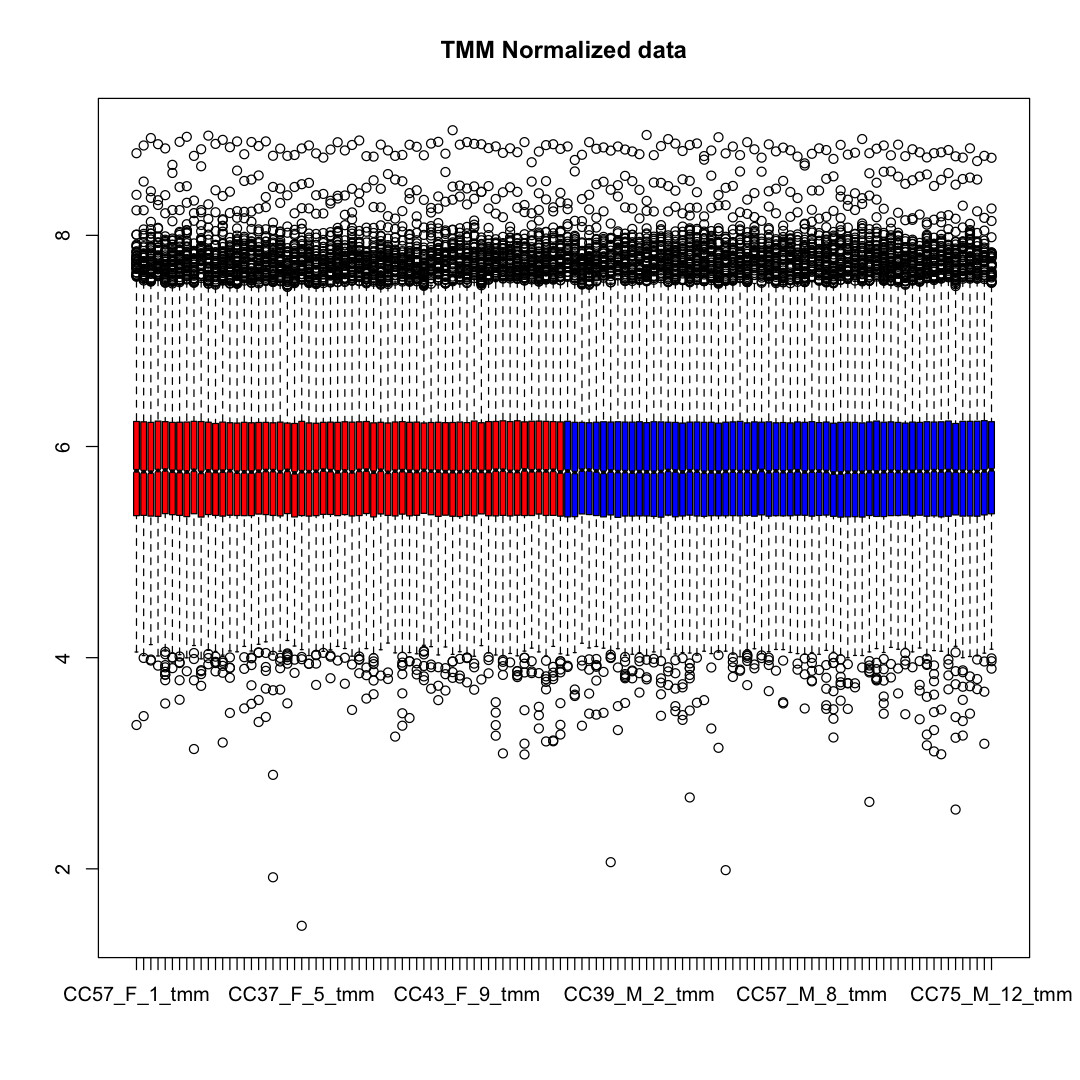

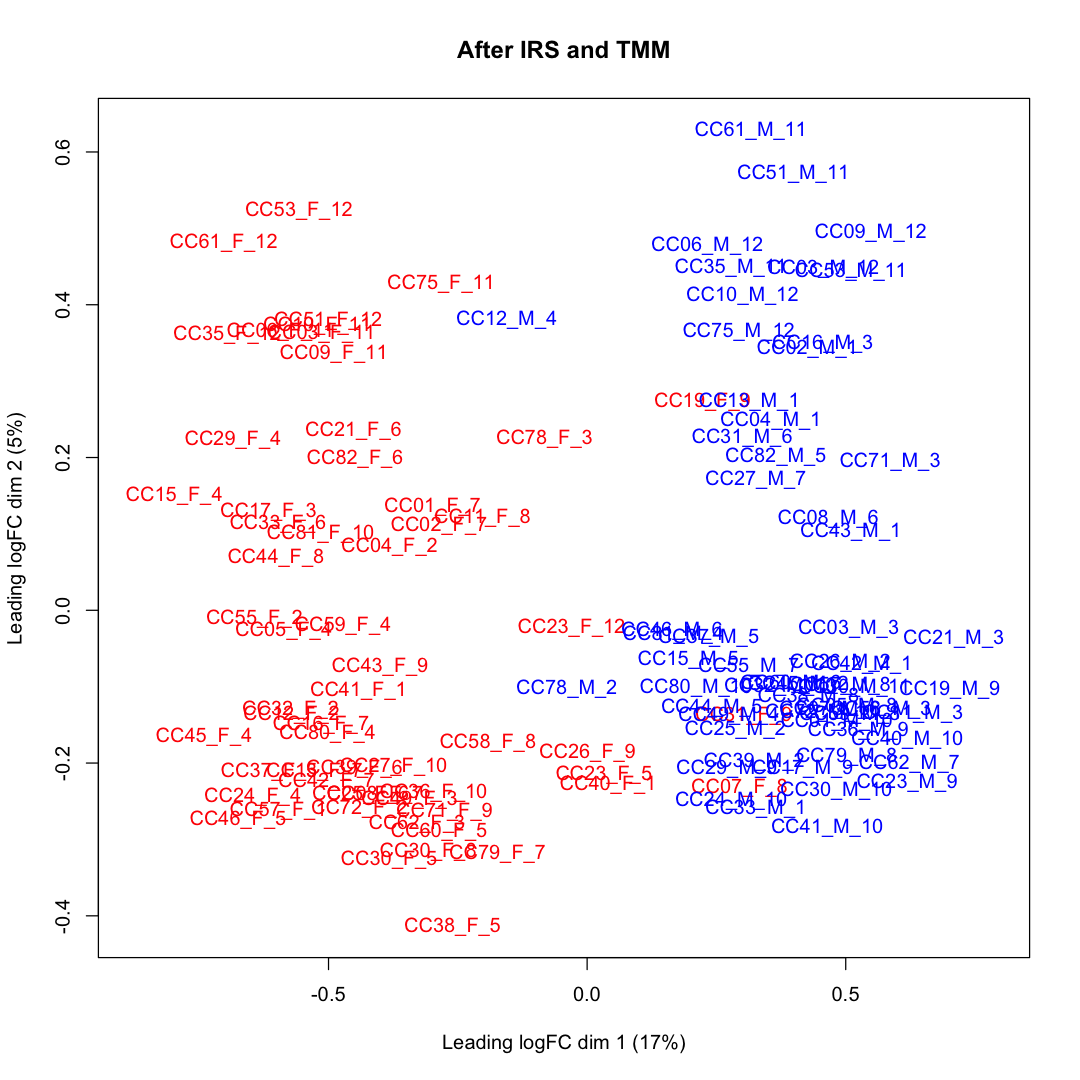

In [7]:
# get the biological sample data into a DGEList object
group = c(rep("F", length(F)), rep("M", length(M)))

y <- DGEList(counts = tmt_irs, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

# compute the TMM-normalized intensities
tmt_tmm <- apply_tmm_factors(y, color = colors_group)

# write the TMM-normalized intensities to file
write.table(cbind(accessions,tmt_tmm), "CC-120_IRS-plus-TMM.txt", sep = "\t", 
            row.names = FALSE, na =  " ")

# check the clustering
plotMDS(y, col = colors_group, main = "After IRS and TMM")

### TMM factors are close to 1.0

Mouse liver samples look like a good tissue to process. Boxplots and normalization factors all suggest good sample-to-sample similarity. The TMM-normalization improved the boxplot alignment and tightened up the clustering a little bit (maybe).

## <a name="CVs"></a>Check CV distributions

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This is an effective way to assess proper normalization in these experiments. We will compute CV distributions for each of the biological conditions.

In [8]:
# put CVs in data frames to simplify plots and summaries
# we will skip the n=1 group (TOFPS)
cv_tmm <- data.frame(F = CV(tmt_tmm[F]), M = CV(tmt_tmm[M]))

medians <- apply(cv_tmm, 2, FUN = median)
print("Final median CVs by condition (%)")
round(medians, 2)

[1] "Final median CVs by condition (%)"


F     M 
15.51 15.35

### Average median CV is 15.4%

Laboratory animals can have quite small median CVs, provided the tissue is not especially challenging to process. Good technical replicates can have median CVs in the 3% range. Animal models can have samples in the 5-7% range for good sample preps up to maybe low teens for harder samples or less reproducible sample processing. This is a diverse mice cohort and there are just two biological groups being defined. Given the large number of samples, a median CV of 15% suggests pretty good sample preparation.

### Use ggplot to visualize the CV distributions

We will look at the final TMM normalized data only.

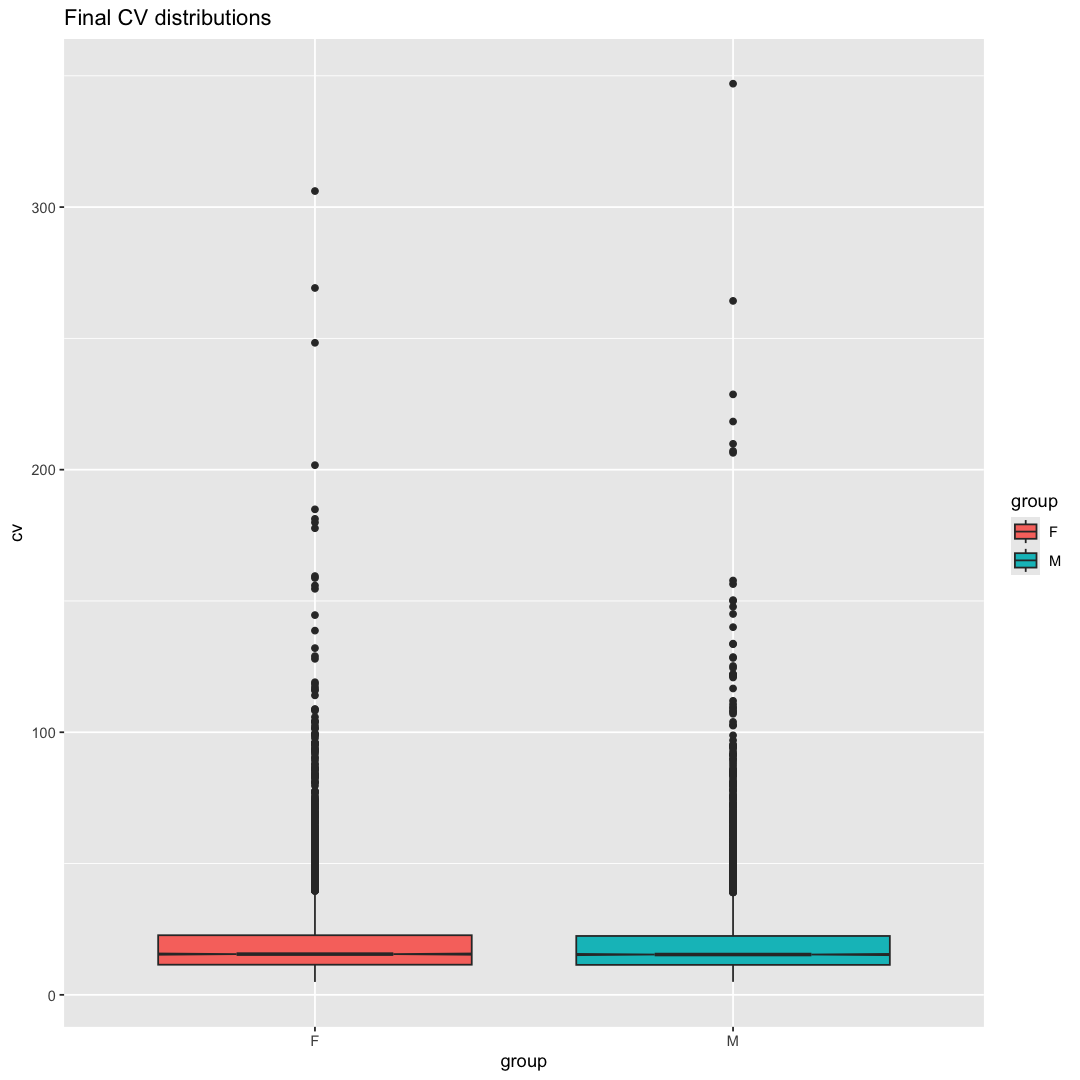

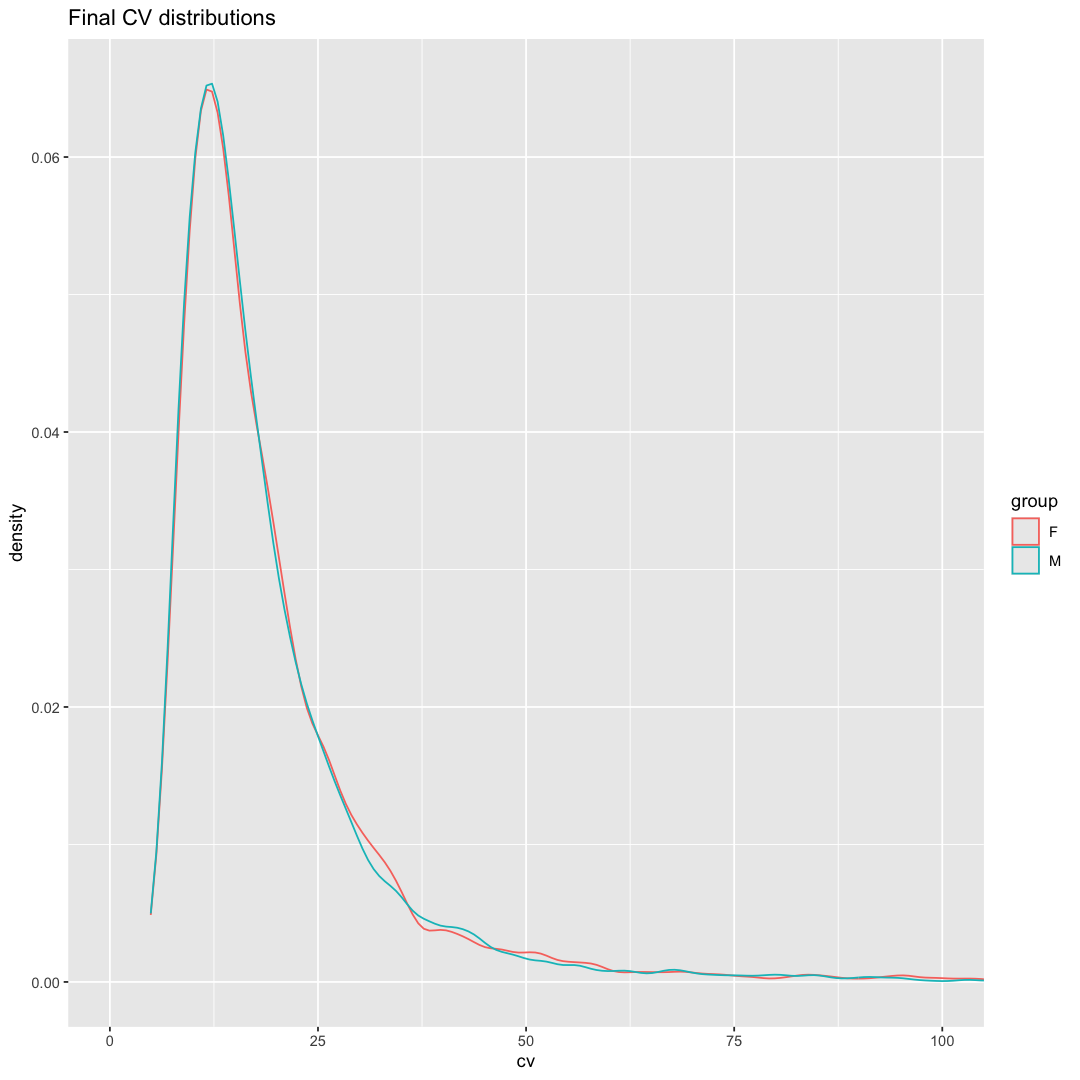

In [9]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv_tmm <- gather(cv_tmm, key = "group", value = "cv") 

# traditional boxplots
ggplot(long_cv_tmm, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("Final CV distributions")

# density plots
ggplot(long_cv_tmm, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 100)) +
  ggtitle("Final CV distributions")

### The two groups have very similar CV distributions

The two groups have very similar CV distributions and median CV values.

## <a name="scatter_plots"></a>Compare sample scatter plots for each biological condition

We can also look at each biological condition with a multi-panel scatter plot grid and see how similar the replicates are to each other. We can look at the intensities after IRS with TMM (final data).

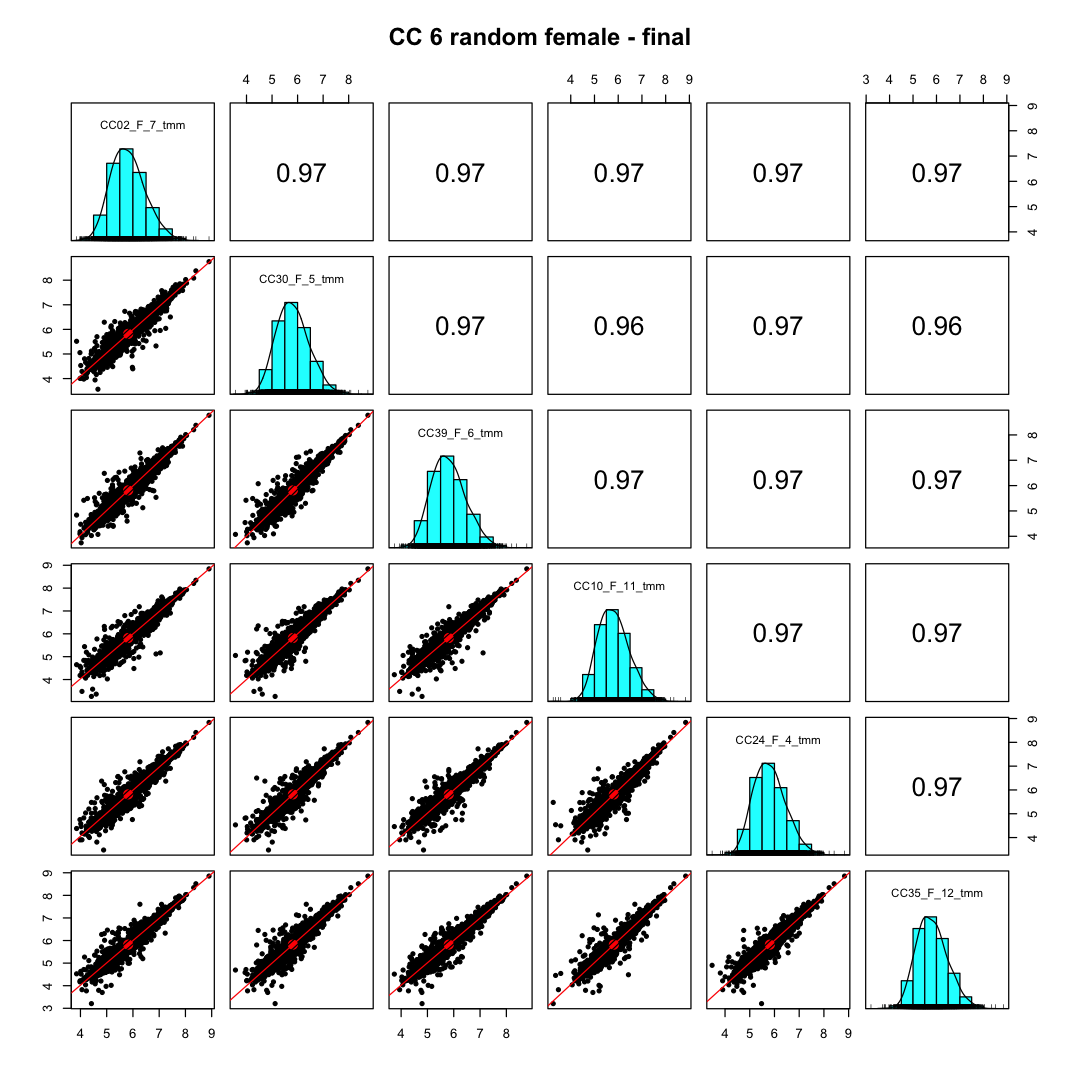

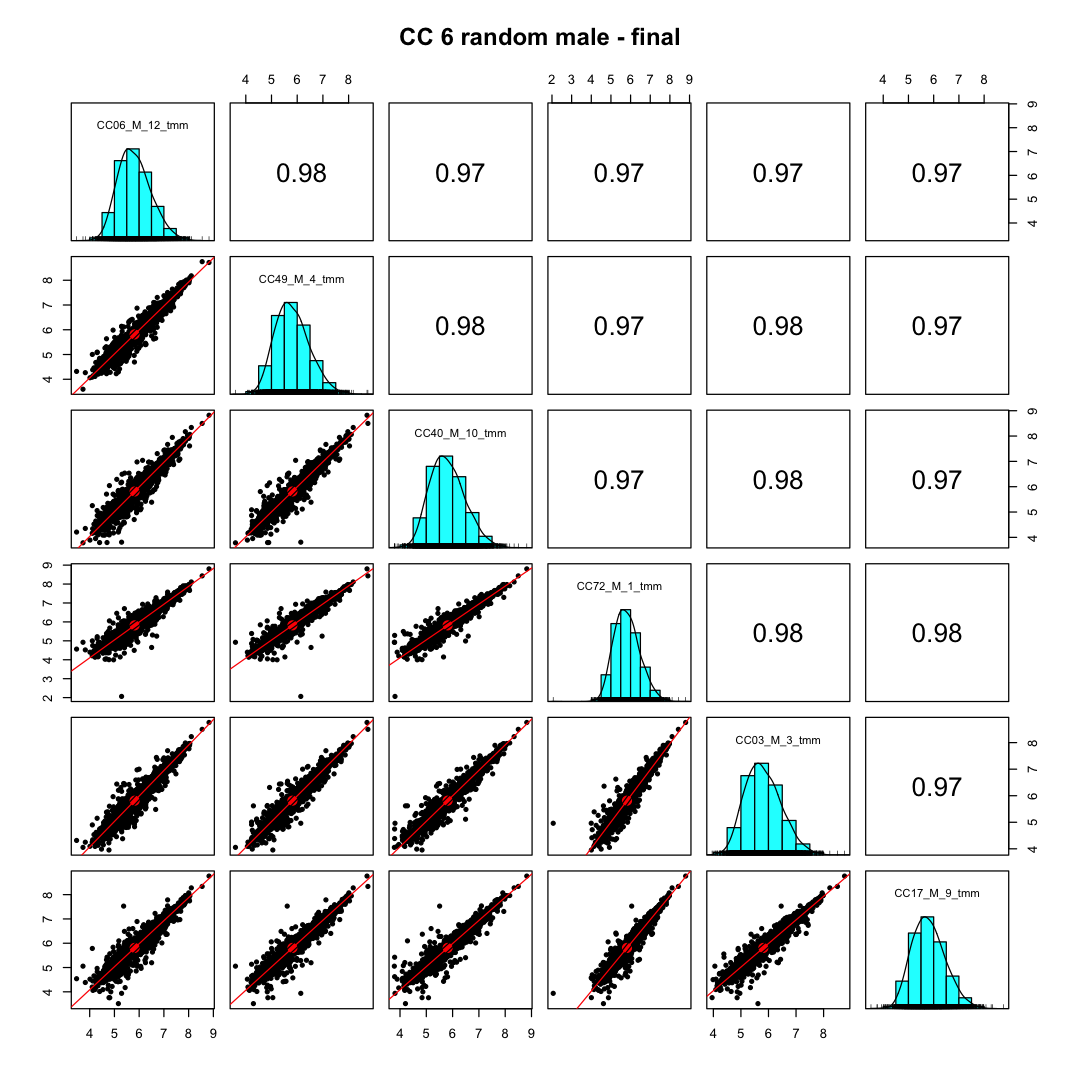

In [10]:
# multi-panel scatter plot grids, final data
pairs.panels(log10(tmt_tmm[sample(F, 6)]), lm = TRUE, main = "CC 6 random female - final")
pairs.panels(log10(tmt_tmm[sample(M, 6)]), lm = TRUE, main = "CC 6 random male - final")

#### There are sample-to-sample differences within groups

### Compare averages of each group to each other

We can get a little heads up on the statistical testing by comparing group averages to each other. 

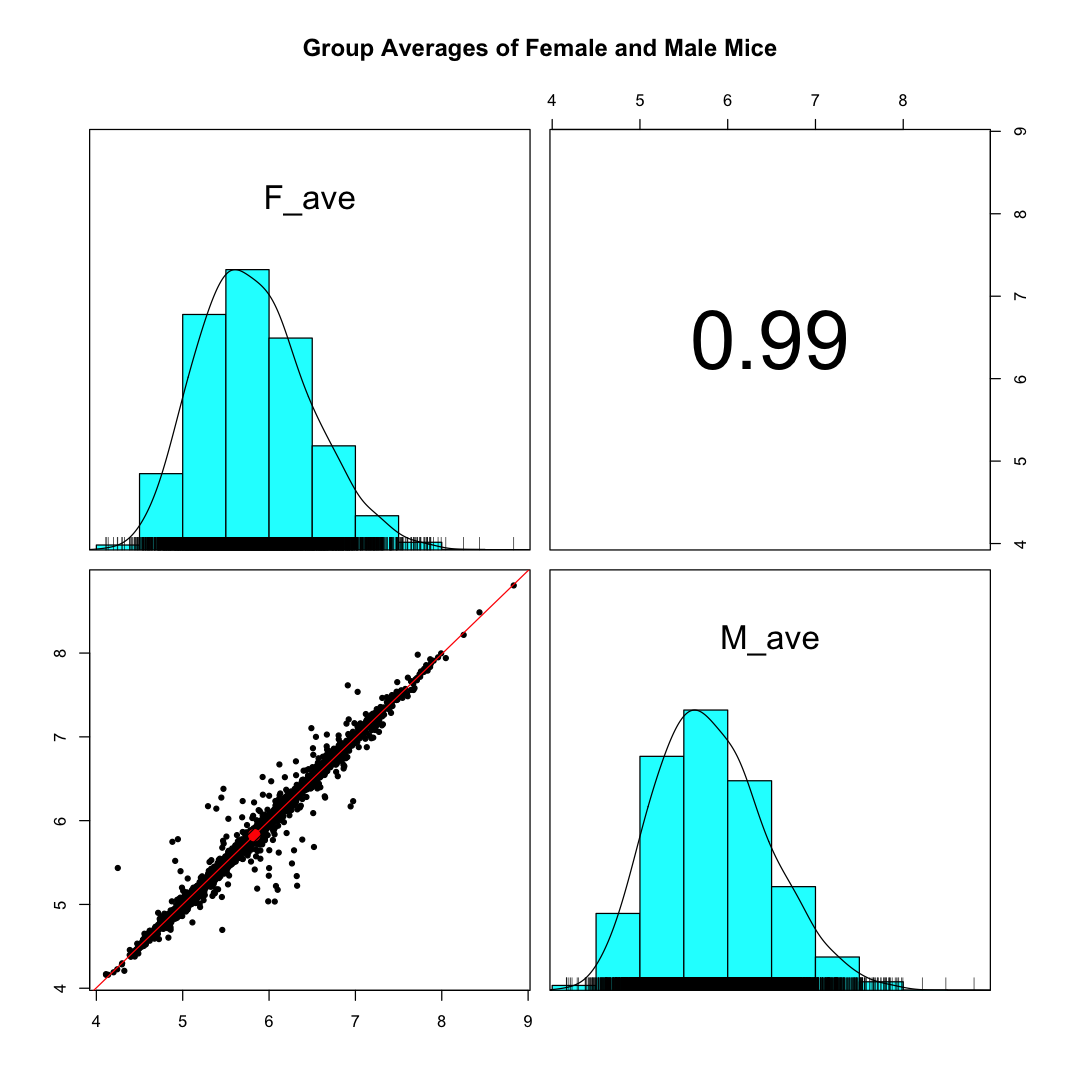

In [11]:
# save the dataframe with the averages by strain and sex
ave_tmm <- cbind(F_ave = rowMeans(tmt_tmm[F]),
                 M_ave = rowMeans(tmt_tmm[M]))

# make a scatter plot grid for the group averages
pairs.panels(log10(ave_tmm), lm = TRUE, main = "Group Averages of Female and Male Mice")

### Females and males have some distinct protein abundance differences

With 60 mice in each group, the majority of proteins have similar average relative abundances between female and male mice. There are a small number of proteins that are quite far from the diagonal trend line (and reasonable balanced bwtween up and down changes).

## <a name="summary"></a> Summary

Quality control checks seem okay. We could move on to statistical testing, if desired. It is not clear what biological groups can be defined and compared besides the male and female groups.

## Log the session information

In [12]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-apple-darwin20
Running under: macOS 15.7.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.4.3     edgeR_4.2.0     limma_3.60.2    scales_1.3.0   
 [5] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [9] purrr_1.0.2     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
[13] ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    stringi_1.8.4     lattice_0.22-6   
 [5] hms_1.1.3         digest_0.6.35     magrittr_2.0.3  